In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
import random
import os
import cv2
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm


In [2]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [3]:
data1 = np.load('../data/data0.npy')
lab1 = np.load('../data/lab0.npy')
data2 = np.load('../data/data1.npy')
lab2 = np.load('../data/lab1.npy')
data3 = np.load('../data/data2.npy')
lab3 = np.load('../data/lab2.npy')

In [4]:
data_cumulative = np.concat([data1,data2,data3])
labels_cumulative = np.concat([lab1,lab2,lab3])
labels = torch.tensor(labels_cumulative, dtype=torch.long)

In [5]:
def process_images(data_cumulative):
    processed_images = []
    for img in data_cumulative:
        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((2, 1), np.uint8)
        binary = cv2.dilate(binary, kernel, iterations=1)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        digit_regions = []
        min_area = 20        
        for i in range(1, num_labels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            
            if area > min_area:
                digit_regions.append((x, y, w, h))
        digit_regions.sort(key=lambda x: x[0])
        digit_images = []
        for x, y, w, h in digit_regions:
            digit = binary[y:y+h, x:x+w]
            digit_with_border = cv2.copyMakeBorder(digit, 10, 10, 10, 10, 
                                                   cv2.BORDER_CONSTANT, value=0)
            resized_digit = cv2.resize(digit_with_border, (28, 28))
            digit_images.append(resized_digit)
        
        if digit_images:
            concatenated_image = np.concatenate(digit_images, axis=1)
            concatenated_image = cv2.resize(concatenated_image, (224, 224))
        else:
            concatenated_image = np.zeros((224, 224), dtype=np.uint8)
        
        image_tensor = torch.tensor(concatenated_image / 255.0, dtype=torch.float32).unsqueeze(0)
        processed_images.append(image_tensor)
    
    return processed_images

processed_images = process_images(data_cumulative)

In [7]:
class ResNetForClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetForClassification, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

class SumDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images = processed_images 
labels = labels_cumulative
dataset = SumDataset(images, labels, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = max(labels_cumulative) + 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetForClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=5e-4, weight_decay=1e-4)
best_acc = 0
for epoch in range(25):
    model.train()
    epoch_loss = 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}")

    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    if (100 * correct / total > best_acc):
        best_acc = 100 * correct / total
        print("Updated Model")
        torch.save(model,"model.pth")
    print(f"Test Accuracy: {100 * correct / total:.2f}% , Val Loss: {val_loss/len(test_loader)}")


100%|██████████| 375/375 [01:35<00:00,  3.95it/s]


Epoch 1, Loss: 2.699926289876302
Updated Model
Test Accuracy: 21.55% , Val Loss: 2.309532880783081


100%|██████████| 375/375 [01:34<00:00,  3.97it/s]


Epoch 2, Loss: 2.0632200838724772
Updated Model
Test Accuracy: 36.43% , Val Loss: 1.6845471858978271


100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


Epoch 3, Loss: 1.827607559521993
Updated Model
Test Accuracy: 40.57% , Val Loss: 1.6405837535858154


100%|██████████| 375/375 [01:34<00:00,  3.99it/s]


Epoch 4, Loss: 1.64345521068573
Updated Model
Test Accuracy: 41.68% , Val Loss: 1.4833636283874512


100%|██████████| 375/375 [01:34<00:00,  3.98it/s]


Epoch 5, Loss: 1.5330441783269246
Updated Model
Test Accuracy: 45.52% , Val Loss: 1.4376622438430786


100%|██████████| 375/375 [01:34<00:00,  3.99it/s]


Epoch 6, Loss: 1.4119726413091023
Updated Model
Test Accuracy: 52.10% , Val Loss: 1.2376830577850342


100%|██████████| 375/375 [01:33<00:00,  3.99it/s]


Epoch 7, Loss: 1.3379861838022868
Updated Model
Test Accuracy: 54.20% , Val Loss: 1.219743013381958


100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


Epoch 8, Loss: 1.2425821431477864
Updated Model
Test Accuracy: 59.40% , Val Loss: 1.1595616340637207


100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


Epoch 9, Loss: 1.186784375667572
Updated Model
Test Accuracy: 65.82% , Val Loss: 1.0914885997772217


100%|██████████| 375/375 [01:34<00:00,  3.98it/s]


Epoch 10, Loss: 1.1691450670560202
Updated Model
Test Accuracy: 66.62% , Val Loss: 1.150016188621521


100%|██████████| 375/375 [01:34<00:00,  3.99it/s]


Epoch 11, Loss: 1.1093458749453227
Updated Model
Test Accuracy: 72.80% , Val Loss: 0.9832439422607422


100%|██████████| 375/375 [01:33<00:00,  3.99it/s]


Epoch 12, Loss: 1.0595789810816447
Test Accuracy: 70.88% , Val Loss: 0.9509578347206116


100%|██████████| 375/375 [01:33<00:00,  3.99it/s]


Epoch 13, Loss: 0.9849948471387228
Updated Model
Test Accuracy: 76.57% , Val Loss: 0.8591808080673218


100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


Epoch 14, Loss: 0.9437268481254578
Test Accuracy: 62.65% , Val Loss: 1.0783056020736694


100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


Epoch 15, Loss: 1.003762158870697
Test Accuracy: 71.37% , Val Loss: 0.9242689609527588


100%|██████████| 375/375 [01:33<00:00,  4.00it/s]


Epoch 16, Loss: 0.9425891542434692
Updated Model
Test Accuracy: 81.70% , Val Loss: 0.7945878505706787


100%|██████████| 375/375 [01:34<00:00,  3.99it/s]


Epoch 17, Loss: 0.9183282248179118
Test Accuracy: 67.70% , Val Loss: 1.3820394277572632


100%|██████████| 375/375 [01:36<00:00,  3.89it/s]


Epoch 18, Loss: 0.8384196570714315
Test Accuracy: 79.98% , Val Loss: 0.7871925234794617


100%|██████████| 375/375 [01:36<00:00,  3.89it/s]


Epoch 19, Loss: 0.8553248912493387
Test Accuracy: 71.97% , Val Loss: 0.8484421968460083


100%|██████████| 375/375 [01:37<00:00,  3.86it/s]


Epoch 20, Loss: 0.7870403564771017
Test Accuracy: 71.82% , Val Loss: 0.9267054200172424


100%|██████████| 375/375 [01:35<00:00,  3.91it/s]


Epoch 21, Loss: 0.7281671070257822
Updated Model
Test Accuracy: 84.13% , Val Loss: 0.7003628015518188


100%|██████████| 375/375 [01:34<00:00,  3.97it/s]


Epoch 22, Loss: 0.7934543880621592
Test Accuracy: 79.40% , Val Loss: 0.8635005950927734


100%|██████████| 375/375 [01:35<00:00,  3.94it/s]


Epoch 23, Loss: 0.780283521493276
Test Accuracy: 79.18% , Val Loss: 0.8487224578857422


100%|██████████| 375/375 [01:35<00:00,  3.93it/s]


Epoch 24, Loss: 0.7581845517953237
Updated Model
Test Accuracy: 85.87% , Val Loss: 0.655259370803833


100%|██████████| 375/375 [01:34<00:00,  3.96it/s]


Epoch 25, Loss: 0.6673240535259247
Test Accuracy: 83.95% , Val Loss: 0.9084388017654419


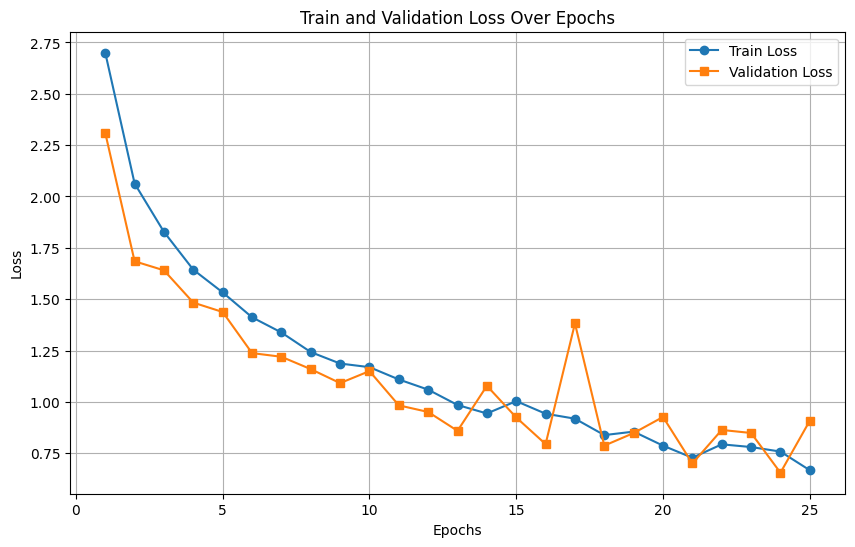

In [8]:
# Data extracted from the output
epochs = list(range(1, 26))
train_losses = [
    2.699926289876302, 2.0632200838724772, 1.827607559521993, 1.64345521068573, 
    1.5330441783269246, 1.4119726413091023, 1.3379861838022868, 1.2425821431477864, 
    1.186784375667572, 1.1691450670560202, 1.1093458749453227, 1.0595789810816447, 
    0.9849948471387228, 0.9437268481254578, 1.003762158870697, 0.9425891542434692, 
    0.9183282248179118, 0.8384196570714315, 0.8553248912493387, 0.7870403564771017, 
    0.7281671070257822, 0.7934543880621592, 0.780283521493276, 0.7581845517953237, 
    0.6673240535259247
]
val_losses = [
    2.309532880783081, 1.6845471858978271, 1.6405837535858154, 1.4833636283874512, 
    1.4376622438430786, 1.2376830577850342, 1.219743013381958, 1.1595616340637207, 
    1.0914885997772217, 1.150016188621521, 0.9832439422607422, 0.9509578347206116, 
    0.8591808080673218, 1.0783056020736694, 0.9242689609527588, 0.7945878505706787, 
    1.3820394277572632, 0.7871925234794617, 0.8484421968460083, 0.9267054200172424, 
    0.7003628015518188, 0.8635005950927734, 0.8487224578857422, 0.655259370803833, 
    0.9084388017654419
]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
